# figure 1, optimal control phase portrait 

In [6]:
import numpy as np
from scipy.integrate import odeint  
from operator import sub 
import controlpy   
import pickle

from matplotlib import  rc    
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rcParams

import phasediagram as phd
import singlependulum as sp  
# import dynamicpendulums.figureparam as fp

from figure_settings import *    
import figure_functions as ff

In [7]:
# General Plotting Parameters 
fig_dim = (3.2, 2.5) 
fig_name = 'fig1_optimal_control'  
 

In [8]:
# file_to_load = 'data\controlU_lookup_Q1_R100.npy'
file_to_load =  r'u_gridfree_highdef.npy'

U_bang,X,Y = np.load( file_to_load )  
print('File loaded: ' + file_to_load)


def simulate_optimal( y0):
    # ---------controller ------------   
    dt = 0.001; 
    tLast =5
    tInt = np.arange(0,tLast+dt, dt) ;
    n_steps = np.int(tLast/dt)
    print('Number of time steps: '+ str(n_steps) )

    L =1.
    g = -10.   
    time_sign =  3

    # ---time step per simulation ------
    t = np.linspace(0,dt,2)  

    y_n = np.zeros( (n_steps,2)  ) 
    Y_dat = [] 
    y_1 = y0 
    u_clip = 3

    U = np.zeros( (n_steps)  )
    for j in range(n_steps):  
        y_n[j,:] = y_1 
#         closest_x =  np.argmin( np.abs(  X[0,:]-y_1[0] ) ) 
        closest_x =  np.argmin( np.abs(  X[0,:]-sp.wrap2periodic(y_1[0])  ) ) 
        closest_y =  np.argmin( np.abs(  Y[:,0]-y_1[1] ) ) 

        U[j] = U_bang[closest_y,closest_x]/2 

        dE= sp.compute_dE(y_1[0],y_1[1]  ) 
        if dE < -19.98:
            U[j] = 0  
        y_2 = odeint(  sp.pendulum_ode, y_1,  t, args=(U[j],time_sign,)  )[1]     # ode solver 

        y_1 = y_2   

    U_n = U 
    
    return( y_n, U_n)

File loaded: u_gridfree_highdef.npy


In [9]:

y0 = np.array([0,1]) 
y_n, U_n = simulate_optimal(y0) 
y_n[0,:] = sp.wrap2periodic(y_n[0,:]) 

y0 = np.array([-1.8*np.pi,8]) 
y_p, U_p = simulate_optimal( y0) 

Number of time steps: 5000
Number of time steps: 5000


In [10]:
U_bang[:20,:] = 3
U_bang[-20:,:] = -3 

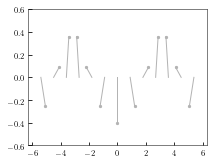

In [11]:
def draw_pendulums_xaxis( ax_p, r = 0.3, n_pendulums = 11, color='k' , linewidth = 1 ):
    angle_list = np.linspace( -np.pi*2, 2*np.pi, n_pendulums )
    
    angle_list = angle_list[1:-1] 
 
    for th in angle_list:
        x  =  np.sin(th) *r
        y = -np.cos(th)*r 
        ax_p.plot( np.array([0,x]) + th ,[0,y],color=color,linewidth = linewidth)  
        ax_p.scatter( th+x,y,5,color=color) 

    ax_p.set_xlim( np.array([-1,1]) *2*np.pi   ) 
    ax_p.set_ylim( np.array([-1,1])*(r+0.2)  )
    
fig,ax1 = plt.subplots(1,1, figsize= fig_dim )

draw_pendulums_xaxis(ax1, r=0.4, n_pendulums = 15, color = np.array([1,1,1])*0.7)

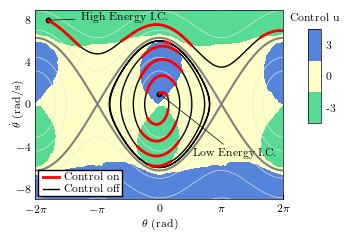

In [12]:


def plot_optimal_control( ax_p, traject_col = traj_col, ff_col= ff_col): 
    ax_p.set_ylim([-9,9])   
    ax_p.set_xlim([-2*np.pi,2*np.pi])

    # plot background 
    ax_p.pcolor(X,Y,U_bang, cmap= contr ) 
    ax_p.pcolor(X-2*np.pi,Y,U_bang, cmap= contr ) 
    pcol= ax_p.pcolor(X+2*np.pi,Y,U_bang, cmap= contr ) 

    
    pcol= ax_p.pcolor(X,Y,U_bang, cmap= contr ) 

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
    axins = inset_axes(ax_p,
                       width="5%",  # width = 5% of parent_bbox width
                       height="50%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.1, 0.4, 1, 1),
                       bbox_transform=ax_p.transAxes,
                       borderpad=0,
                       ) 

    cbar = fig.colorbar(pcol, cax=axins , ticks=[-2,0,2] )
    cbar.ax.set_yticklabels([-3,0,3])  # vertically oriented colorbar
    cbar.ax.set_title('Control u')  
 

    # plot energy contours 
    ff.plot_add_contours(ax_p) 

    # plot homoclinic orbit 
    phd.homoclinic_plot(ax_p  ,-2*np.pi,2*np.pi, col=homoclinic_col) 
#     homoclinic_plot(ax  ,-2*np.pi,2*np.pi) 


    # plot negative line    
    ff.plot_discontinuous_lines(ax_p, y_n,linewidth =1, color=traject_col)
    
    u_bool = np.abs(U_n)>0.1 
    y_data = y_n[u_bool] 
    
    ff.plot_discontinuous_lines(ax_p, y_data, color= ff_col)

    # plot positive line
    ax_p.plot( y_p[:,0], y_p[:,1] ,linewidth =1, color=traject_col)
    u_bool = np.abs(U_p)>0.1 
    y_data = y_p[u_bool]     
    
    ff.plot_discontinuous_lines(ax_p, y_data, color=ff_col)

    ax_p.xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
    ax_p.xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter())) 
     
        
    ax_p.yaxis.set_major_locator(plt.MultipleLocator(4)) 
    
    y0 = y_p[0,:]
    ax_p.scatter( y0[0], y0[1],10,'k') 
    ax_p.annotate( 'High Energy I.C.', y0, xytext=(-4,8),
                arrowprops=dict( arrowstyle='-',color='k',lw=0.5), fontsize = annotate_font )
    
    
    y0 = y_n[0,:]
    ax_p.scatter( y0[0], y0[1],10,'k') 
    ax_p.annotate( 'Low Energy I.C.', y0, xytext=(1.7,-5),
                arrowprops=dict( arrowstyle='-',color='k',lw=0.5) , fontsize = annotate_font ) 
    
    
    ax_p.plot([-10,-10],[-10,-10],'r', label = 'Control on',linewidth =2)
    ax_p.plot([-10,-10],[-10,-10],'k',label='Control off',linewidth =1)
 
    
    ax_p.legend( fontsize = 8,loc='lower left')
    
    ax_p.set_xlabel(r'$\theta$ (rad)' )
    ax_p.set_ylabel(r'$\dot{\theta}$ (rad/s)',   va = 'top') 
    return( ax_p) 


fig, ax = plt.subplots(1,1,figsize = (fig_dim), dpi = 100 )

plot_optimal_control(ax)  
 

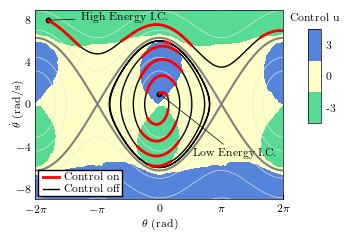

In [13]:
fig, ax = plt.subplots(1,1,figsize = (fig_dim), dpi = 100 )
 
plot_optimal_control(ax)  
   
# plt.savefig('./figs/' + fig_name + '.png',
#         format='png', dpi=300,
#         transparent=  True,             
#         bbox_inches = 'tight', pad_inches = 0,
#         )
# plt.savefig('./figs/' + fig_name + '.svg',
#         format='svg',  transparent= True,
#         bbox_inches = 'tight', pad_inches = 0,
#         ) 

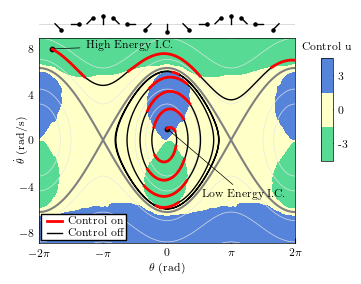

In [14]:
# fig, (a0,ax1) = plt.subplots(1,1,figsize = (fig_dim), dpi = 100 )

fig = plt.figure( figsize= fig_dim,dpi = 100) 
ax0= plt.axes([ 0 , 0.8 , .8 ,  .15] )  
ax1= plt.axes([ 0, 0, .8, 0.82])  # standard axes  


plot_optimal_control(ax1)  
draw_pendulums_xaxis(ax0, r=0.4, n_pendulums =17, color = np.array([1,1,1])*0,linewidth = 1)
 
ax0.set_aspect('equal', adjustable='box' )
ax0.axis('off') 

ax0.plot( [-2*np.pi,2*np.pi],[0,0], zorder = -1,color = np.array([1,1,1])*0.8, linewidth = 0.5 )


# # # # # save fig  -----------------------------------------------------------------------
save_fig = False
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )
    plt.savefig('./figs/' + fig_name + '.svg',
            format='svg',  transparent= True,
            bbox_inches = 'tight', pad_inches = 0,
            )   
    plt.savefig('./figs/' + fig_name + '.pdf',
            format='pdf',  transparent= True, 
            bbox_inches = 'tight', pad_inches = 0,
            )  
    plt.close()